### ADZD Lab3 - Klaster 
#### Katarzyna Główczyk

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
spark = SparkSession.builder.getOrCreate()
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1730707856989_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1730707856989_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1730707856989_0002,pyspark,idle,Link,Link,None,✔


In [3]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("geopy")
sc.install_pypi_package("pycountry")
sc.install_pypi_package("geopandas")
sc.install_pypi_package("plotly")
sc.install_pypi_package("IPython")
sc.install_pypi_package("kaleido")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1730707856989_0002/container_1730707856989_0002_01_000001/tmp/spark-8027847a-220e-4660-9427-2039dd76e727
    Can't uninstall 'python-dateutil'. No files were found to uninstall.






  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.24
    Not uninstalling prompt-toolkit at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1730707856989_0002/container_1730707856989_0002_01_000001/tmp/spark-8027847a-220e-4660-9427-2039dd76e727
    Can't uninstall 'prompt-toolkit'. No files were found to uninstall.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [4]:
from pyspark.sql.functions import col, asc, desc, max, to_timestamp, avg, to_utc_timestamp, date_trunc, row_number, to_date, udf, lit
import matplotlib.pyplot as plt
import pandas as pd
import time
from geopy.geocoders import Nominatim
from pyspark.sql.window import Window
import unicodedata
from pyspark.sql.types import StringType, DoubleType
import geopandas as gpd
import plotly.io as pio
import plotly.express as px
from IPython.display import Image, display
from functools import reduce
import math

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
start = time.time()

smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz")
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz")\

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

215.67835974693298

In [6]:
smog_df.cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: string]

In [7]:
start = time.time()
smog_df.count()
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

115.91326403617859

In [8]:
smog_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)

In [9]:
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Simple queries

In [10]:
smog_df.limit(10).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+------------------------------------+-------------------------+---------+---------+---------+-----+-------+
|location_id|sensors_id|location                            |datetime                 |lat      |lon      |parameter|units|value  |
+-----------+----------+------------------------------------+-------------------------+---------+---------+---------+-----+-------+
|10618      |35276     |Kędzierzyn-Koźle, ul. Śmiałego-10618|2022-05-17T01:00:00+02:00|50.349608|18.236575|pm10     |µg/m³|15.62  |
|10618      |35276     |Kędzierzyn-Koźle, ul. Śmiałego-10618|2022-05-17T02:00:00+02:00|50.349608|18.236575|pm10     |µg/m³|13.6041|
|10618      |35276     |Kędzierzyn-Koźle, ul. Śmiałego-10618|2022-05-17T03:00:00+02:00|50.349608|18.236575|pm10     |µg/m³|13.7349|
|10618      |35276     |Kędzierzyn-Koźle, ul. Śmiałego-10618|2022-05-17T04:00:00+02:00|50.349608|18.236575|pm10     |µg/m³|15.1872|
|10618      |35276     |Kędzierzyn-Koźle, ul. Śmiałego-10618|2022-05-17T05:0

In [11]:
smog_df.select('parameter').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+
|parameter|
+---------+
|       co|
|     pm10|
|      so2|
|      no2|
|       bc|
|     pm25|
|       o3|
+---------+

Some more interesting statistics

In [12]:
start = time.time()
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .groupby('location').agg(max('value').alias('max_pm10'))\
            .sort(desc('max_pm10'))

max_pm10.limit(100).show(truncate=False)
end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------+-----------+
|location                                        |max_pm10   |
+------------------------------------------------+-----------+
|Ballygunge, Kolkata - WBPCB-10918               |9999.9     |
|Govt. High School Shikarpur, Patna - BSPCB-10630|5631.1     |
|Sanjay Nagar, Ghaziabad - UPPCB-10919           |3490.0     |
|New Industrial Town, Faridabad - HSPCB-10920    |2217.0     |
|Mundka, Delhi - DPCC-10486                      |1787.0     |
|Sector 30, Faridabad - HSPCB-10820              |1309.16    |
|Nedre Langgate-10492                            |1187.386375|
|Mini Secretariat, Charkhi Dadri - HSPCB-10725   |1186.4     |
|Sector 11, Faridabad - HSPCB-10908              |1090.9     |
|Rajbansi Nagar, Patna - BSPCB-10599             |1003.2     |
|Sector-51, Gurugram - HSPCB-10825               |999.99     |
|Rishi Nagar, Kaithal - HSPCB-10905              |999.99     |
|Murthal, Sonipat - HSPCB-10906                  |999.9

In [13]:
smog_df.filter(col('location').contains('Krak')).select('location').distinct().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------+
|location                        |
+--------------------------------+
|Kraków, ul. Bulwarowa-10516     |
|Kraków, Aleja Krasińskiego-10752|
+--------------------------------+

In [14]:
max_pm10.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- location: string (nullable = true)
 |-- max_pm10: double (nullable = true)

In [15]:
plt.figure()
max_pm10.limit(10).toPandas().plot.barh(x='location')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Axes: ylabel='location'>

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

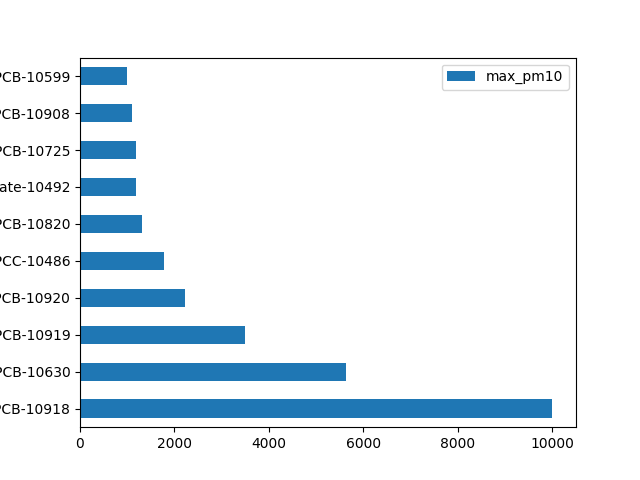

In [16]:
%matplot plt

[1p.] Znajdź miasta, w których średnie stężenie pyłu “pm25” było niższe niż maksymalne stężenie w jednym wybranym mieście (w całym badanym okresie). Obliczenia wykonaj dla danych z kilku dni. Wyniki posortuj malejąco po stężeniu pm25.

In [17]:
smog_df.select('location').distinct().show(100, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------+
|location                                        |
+------------------------------------------------+
|Kalisz, ul. Wyszyńskiego-10616                  |
|Jelenia Góra, ul. Ogińskiego-10625              |
|Elbląg, ul. Bażyńskiego-10691                   |
|Kędzierzyn-Koźle, ul. Śmiałego-10618            |
| Olsztyn, ul. Puszkina-10743                    |
|Gdańsk, ul. Leczkowa-10757                      |
|Wrocław, wyb. Conrada-Korzeniowskiego-10566     |
|Wschowa ul. Kazimierza Wielkiego-10511          |
|Poznań, ul. Dąbrowskiego-10720                  |
|RS0036A-10879                                   |
|Rybnik, ul. Borki-10542                         |
|Ostróda, ul. Piłsudskiego-10744                 |
|Otwock, ul. Brzozowa-10575                      |
|Gdynia, ul. Porębskiego-10760                   |
|Złoty Potok, Leśniczówka-10454                  |
|Rzeszów, ul. Rejtana-10544                      |
|Kraków, ul. Bulwarowa-10516   

In [18]:
smog_df.select('lat', 'lon').distinct().show(100, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----------------+
|lat             |lon             |
+----------------+----------------+
|53.789233       |20.486075       |
|50.913433       |15.765608       |
|51.748103       |18.04931        |
|54.380279       |18.620274       |
|51.129378       |17.02925        |
|50.349608       |18.236575       |
|54.167847       |19.410942       |
|51.799722       |16.3175         |
|52.420319       |16.877289       |
|50.111181       |18.516139       |
|53.694587       |19.969041       |
|54.560836       |18.493331       |
|52.115725       |21.237297       |
|44.803179       |20.400152       |
|50.710889       |19.458797       |
|50.024242       |22.010575       |
|43.322554       |21.919025       |
|50.069308       |20.053492       |
|49.784339       |22.756239       |
|52.550938       |19.709791       |
|28.4227         |77.0667         |
|25.697189       |85.2459         |
|59.92305        |10.76574        |
|54.353336       |18.635283       |
|54.400833       |18.657497 

In [19]:
geolocator = Nominatim(user_agent="smog_data_analysis")


def get_city_from_coords(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location:
            address = location.raw.get('address', {})
            # Attempt to get city-like information with fallbacks in decreasing specificity
            return (
                address.get('city') or
                address.get('town') or
                address.get('village') or
                address.get('hamlet') or
                address.get('suburb') or
                address.get('municipality') or
                address.get('county')
            )
    except Exception as e:
        print(f"Error fetching city for coordinates ({lat}, {lon}): {e}")
    return None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
unique_locations = smog_df.select("lat", "lon").distinct().toPandas()
unique_locations['city'] = unique_locations.apply(lambda row: get_city_from_coords(row['lat'], row['lon']), axis=1)
unique_locations_spark = spark.createDataFrame(unique_locations)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
smog_df_with_city = smog_df.join(unique_locations_spark, on=['lat', 'lon'], how='left')
smog_df_with_city.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+----------+--------------------+--------------------+---------+-----+-------+----------------+
|      lat|      lon|location_id|sensors_id|            location|            datetime|parameter|units|  value|            city|
+---------+---------+-----------+----------+--------------------+--------------------+---------+-----+-------+----------------+
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|     pm10|µg/m³|  15.62|Kędzierzyn-Koźle|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|     pm10|µg/m³|13.6041|Kędzierzyn-Koźle|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|     pm10|µg/m³|13.7349|Kędzierzyn-Koźle|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|     pm10|µg/m³|15.1872|Kędzierzyn-Koźle|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T05:00:...|     pm10|µg/m³|13

In [22]:
smog_df_with_city.select('city').distinct().show(100, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+
|city                     |
+-------------------------+
|Rybnik                   |
|Jelenia Góra             |
|Olsztyn                  |
|Kalisz                   |
|Otwock                   |
|Wschowa                  |
|Kędzierzyn-Koźle         |
|Wrocław                  |
|Београд                  |
|Ponik                    |
|Ostróda                  |
|Przemyśl                 |
|Kraków                   |
|Ниш                      |
|Elbląg                   |
|Rzeszów                  |
|Gdańsk                   |
|Poznań                   |
|Gdynia                   |
|Bidhannagar              |
|Oslo                     |
|Charkhi Dadri            |
|Chikkamagaluru           |
|Lublin                   |
|Katowice                 |
|Belsk Duży               |
|Faridabad                |
|Zabrze                   |
|Hajipur                  |
|Gurgaon                  |
|Tarnów                   |
|Zone 2 Manali            |
|Gołdap             

In [23]:
null_city_rows = smog_df_with_city \
    .filter(col("city").isNull()) \
    .select("location", "lat", "lon") \
    .distinct()

null_city_rows.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---+---+
|location|lat|lon|
+--------+---+---+
+--------+---+---+

In [24]:
smog_df_with_city = smog_df_with_city.withColumn('timestamp', to_timestamp(col('datetime')))

start_date = '2022-05-01'
end_date = '2022-05-07'

pm25_df = smog_df_with_city.filter(col('parameter') == 'pm25')
pm25_df_filtered_dates = pm25_df.filter((col('timestamp') >= start_date) & (col('timestamp') <= end_date))

max_pm25_in_city = pm25_df.filter(col('city') == 'Warszawa').agg(max('value').alias('max_pm25')).collect()[0]['max_pm25']

cities_with_lower_avg_pm25 = pm25_df_filtered_dates.groupBy('city').agg(avg('value').alias('avg_pm25')) \
                            .filter(col('avg_pm25') < max_pm25_in_city) \
                            .orderBy(desc('avg_pm25'))

cities_with_lower_avg_pm25.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------------------+
|            city|          avg_pm25|
+----------------+------------------+
|        Jabalpur| 49.38235294117647|
|       Ghaziabad| 49.21739130434783|
|      Chandigarh| 48.17764705882354|
|          Bhopal| 48.06060606060606|
|Pithampur Tahsil| 46.76470588235294|
|         Hajipur|             46.47|
| Padre Las Casas|           44.6875|
|           Haora| 43.17365384615387|
|           Patna| 41.79727891156463|
|       Hyderabad|             41.75|
|     Muzaffarpur| 40.54229166666667|
|          Karnal| 40.04941176470589|
|          Kollam| 34.66070796460176|
|   Zone 2 Manali|34.145961538461535|
|       Kozhikode| 32.82588235294117|
|          Kannur|31.837115384615384|
|        Racibórz| 30.99341340425532|
|        Radomsko|27.104166666666668|
|       Bagalkote|26.102608695652176|
|     Bidhannagar| 25.25451612903226|
+----------------+------------------+
only showing top 20 rows

[1p.] Dla danych z wybranych kilku dni przedstaw w ujęciu godzinowym (wybierz czas UTC) najwyższe zanotowane stężenie pm10 w poszczególnych miastach z całego zbioru danych. Wyniki posortuj po rosnąco datach.

In [25]:
start_date = "2022-05-01"
end_date = "2022-05-07"

pm10_df = smog_df_with_city.filter(
    (col('parameter') == 'pm10') & 
    (col('datetime') >= start_date) & 
    (col('datetime') <= end_date)
)

pm10_df = pm10_df.withColumn('datetime_utc', to_utc_timestamp(col('datetime'), 'UTC')) \
                 .withColumn('date_hour', date_trunc('hour', col('datetime_utc')))

max_pm10_per_hour = pm10_df.groupBy('date_hour', 'city') \
                           .agg(max('value').alias('max_pm10'))

max_pm10_per_hour.orderBy('date_hour', ascending=True).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---------------+--------+
|date_hour          |city           |max_pm10|
+-------------------+---------------+--------+
|2022-04-30 18:00:00|Kolkata        |37.4    |
|2022-04-30 18:00:00|Sultanpuri     |1157.0  |
|2022-04-30 18:00:00|Patna          |159.8   |
|2022-04-30 18:00:00|Haora          |48.76   |
|2022-04-30 18:00:00|Kannur         |66.32   |
|2022-04-30 19:00:00|Kollam         |85.24   |
|2022-04-30 19:00:00|Hyderabad      |120.0   |
|2022-04-30 19:00:00|Patna          |278.1   |
|2022-04-30 19:00:00|Sultanpuri     |1047.0  |
|2022-04-30 19:00:00|Kannur         |59.0    |
|2022-04-30 19:00:00|Hallada Koppalu|50.18   |
|2022-04-30 19:00:00|Hajipur        |78.6    |
|2022-04-30 19:00:00|Muzaffarpur    |44.93   |
|2022-04-30 19:00:00|Haora          |48.14   |
|2022-04-30 19:00:00|Kolkata        |36.3    |
|2022-04-30 19:00:00|Gurugram       |198.0   |
|2022-04-30 19:00:00|Charkhi Dadri  |175.6   |
|2022-04-30 20:00:00|Haora          |48.08   |
|2022-04-30 2

In [26]:
max_pm10_per_hour.orderBy('date_hour', ascending=True).show(truncate=False)
#%%
window_spec = Window.partitionBy('date_hour').orderBy(col('value').desc())

pm10_with_rownum = pm10_df.withColumn('row_number', row_number().over(window_spec))

top_pm10_per_hour = pm10_with_rownum.filter(col('row_number') == 1) \
                                    .select('date_hour', 'city', col('value').alias('max_pm10')) \
                                    .orderBy('date_hour')

top_pm10_per_hour.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---------------+--------+
|date_hour          |city           |max_pm10|
+-------------------+---------------+--------+
|2022-04-30 18:00:00|Kolkata        |37.4    |
|2022-04-30 18:00:00|Sultanpuri     |1157.0  |
|2022-04-30 18:00:00|Patna          |159.8   |
|2022-04-30 18:00:00|Haora          |48.76   |
|2022-04-30 18:00:00|Kannur         |66.32   |
|2022-04-30 19:00:00|Kollam         |85.24   |
|2022-04-30 19:00:00|Hyderabad      |120.0   |
|2022-04-30 19:00:00|Patna          |278.1   |
|2022-04-30 19:00:00|Sultanpuri     |1047.0  |
|2022-04-30 19:00:00|Kannur         |59.0    |
|2022-04-30 19:00:00|Hallada Koppalu|50.18   |
|2022-04-30 19:00:00|Hajipur        |78.6    |
|2022-04-30 19:00:00|Muzaffarpur    |44.93   |
|2022-04-30 19:00:00|Haora          |48.14   |
|2022-04-30 19:00:00|Kolkata        |36.3    |
|2022-04-30 19:00:00|Gurugram       |198.0   |
|2022-04-30 19:00:00|Charkhi Dadri  |175.6   |
|2022-04-30 20:00:00|Haora          |48.08   |
|2022-04-30 2

[1p.] Znajdź ranking miast w Europie pod względem średniego zanieczyszczenia liczonego dla N najwyższych pomiarów pod względem “pm25” dla danych z kilku dni. 

In [46]:
N = 10

pm25_df = smog_df_with_city.filter(
    (col('parameter') == 'pm25') & 
    (col('datetime') >= start_date) & 
    (col('datetime') <= end_date)
)

window_spec = Window.partitionBy("city").orderBy(desc("value"))

ranked_pm25_df = pm25_df.withColumn("rank", row_number().over(window_spec))
top_n_pm25_df = ranked_pm25_df.filter(col("rank") <= N)

city_avg_pm25_df = top_n_pm25_df.groupBy("city") \
                                .agg(avg("value").alias("avg_top_n_pm25")) \
                                .orderBy(desc("avg_top_n_pm25"))

city_avg_pm25_df.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+------------------+
|city                     |avg_top_n_pm25    |
+-------------------------+------------------+
|Faridabad                |403.37000000000006|
|Sultanpuri               |194.8             |
|Charkhi Dadri            |167.01000000000005|
|Kotwali Tehsil           |151.6             |
|Gurugram                 |131.68            |
|Gurgaon                  |104.81700000000001|
|Rohini                   |98.7              |
|Narela Industrial Complex|97.5              |
|Najafgarh                |95.7              |
|Lado Sarai               |90.2              |
|Ajmer                    |83.50999999999998 |
|Kaithal                  |80.77999999999999 |
|Hyderabad                |74.3              |
|Hajipur                  |72.53             |
|Patna                    |70.9              |
|Radomsko                 |69.2              |
|Starachowice             |67.767            |
|Jabalpur                 |67.6              |
|Ghaziabad   

[2p.] Zwizualizuj na mapie średnie zanieczyszczenie w danym kraju dla wybranych kilku dni względem czasu (mapa + slider czasu albo zbiór klatek i animacja) dla wybranych państw.

In [28]:
geolocator = Nominatim(user_agent="smog_data_analysis")

def get_location_from_coords(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location:
            address = location.raw.get('address', {})
            city = (
                address.get('city') or
                address.get('town') or
                address.get('village') or
                address.get('hamlet') or
                address.get('suburb') or
                address.get('municipality') or
                address.get('county')
            )
            country = address.get('country')
            return city, country
    except Exception as e:
        print(f"Error fetching location for coordinates ({lat}, {lon}): {e}")
    return None, None

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
unique_locations = smog_df.select("lat", "lon").distinct().toPandas()
unique_locations[['city', 'country']] = unique_locations.apply(
    lambda row: pd.Series(get_location_from_coords(row['lat'], row['lon'])),
    axis=1
)
unique_locations_spark = spark.createDataFrame(unique_locations)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
smog_df_with_location = smog_df.join(unique_locations_spark, on=['lat', 'lon'], how='left')
smog_df_with_location.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+----------+--------------------+--------------------+---------+-----+-------+----------------+-------+
|      lat|      lon|location_id|sensors_id|            location|            datetime|parameter|units|  value|            city|country|
+---------+---------+-----------+----------+--------------------+--------------------+---------+-----+-------+----------------+-------+
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|     pm10|µg/m³|  15.62|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|     pm10|µg/m³|13.6041|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|     pm10|µg/m³|13.7349|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|     pm10|µg/m³|15.1872|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędz

In [31]:
null_rows = smog_df_with_location \
    .filter(col("country").isNull()) \
    .select("location", "lat", "lon") \
    .distinct()

null_rows.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---+---+
|location|lat|lon|
+--------+---+---+
+--------+---+---+

In [32]:
filtered_df = smog_df_with_location.filter(
    (col("datetime") >= start_date) & 
    (col("datetime") <= end_date)
)

daily_avg_df = filtered_df.withColumn("date", to_date(col("datetime"))) \
                          .groupBy("country", "date") \
                          .agg(avg("value").alias("avg_pm10"))

daily_avg_pd = daily_avg_df.toPandas()
daily_avg_pd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

      country        date    avg_pm10
0       India  2022-05-02  132.003472
1       India  2022-05-05  150.395683
2      Polska  2022-05-06   59.092817
3      Polska  2022-05-01   87.451330
4       Norge  2022-05-06   18.504646
..        ...         ...         ...
70  Slovenija  2022-05-04   16.088235
71  Australia  2022-05-04    3.484000
72  Slovenija  2022-05-06   14.470588
73  Slovenija  2022-05-01   15.152174
74  Australia  2022-05-01    3.357436

[75 rows x 3 columns]

In [33]:
smog_df_with_location.select('country').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|      country|
+-------------+
|       Србија|
|       Polska|
|        India|
|      România|
|        Norge|
|    Australia|
|United States|
|      Sverige|
|       México|
|        Ελλάς|
|    Nederland|
|       Canada|
|        Chile|
|    Slovenija|
+-------------+

In [34]:
def normalize_country_name_unicode(country_name):
    country_name_normalized = ''.join(
        c for c in unicodedata.normalize('NFKD', country_name) if not unicodedata.combining(c)
    )
    
    country_name_mapping = {
        'Србија': 'Serbia',
        'Ελλας': 'Greece',
        'România': 'Romania',
        'Norge': 'Norway',
        'Sverige': 'Sweden',
        'México': 'Mexico',
        'Nederland': 'Netherlands',
        'Slovenija': 'Slovenia',
        'Polska': 'Poland'
    }
    
    if country_name in country_name_mapping:
        return country_name_mapping[country_name]
    return country_name_normalized

normalize_country_name_unicode_udf = udf(normalize_country_name_unicode, StringType())
smog_df_with_location = smog_df_with_location.withColumn("country_normalized", normalize_country_name_unicode_udf(col("country")))

smog_df_with_location.select('country', 'country_normalized').distinct().show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------------------+
|country      |country_normalized|
+-------------+------------------+
|Polska       |Poland            |
|Србија       |Србија            |
|India        |India             |
|România      |Romania           |
|Norge        |Norway            |
|Australia    |Australia         |
|United States|United States     |
|México       |Mexico            |
|Sverige      |Sweden            |
|Ελλάς        |Ελλας             |
|Nederland    |Netherlands       |
|Canada       |Canada            |
|Chile        |Chile             |
|Slovenija    |Slovenia          |
+-------------+------------------+

In [35]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(url)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
pm10_data = smog_df_with_location.filter((col("parameter") == "pm10") &
                                         (col("datetime") >= start_date) &
                                         (col("datetime") <= end_date))

daily_avg_pm10 = pm10_data.withColumn("date", to_date("datetime")) \
                          .groupBy("country_normalized", "date") \
                          .agg(avg("value").alias("avg_pm10"))

daily_avg_pm10_pd = daily_avg_pm10.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
map_data = world.merge(daily_avg_pm10_pd, left_on="ADMIN", right_on="country_normalized", how="right")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
unmatched_countries = set(daily_avg_pm10_pd['country_normalized']) - set(world['ADMIN'])
print("Kraje bez dopasowania:", unmatched_countries)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Kraje bez dopasowania: {'United States', 'Србија', 'Ελλας'}

In [39]:
country_correction = {
    'United States': 'United States of America',
    'Србија': 'Serbia',
    'Ελλας': 'Greece'
}

daily_avg_pm10_pd['country_normalized'] = daily_avg_pm10_pd['country_normalized'].replace(country_correction)

unmatched_countries = set(daily_avg_pm10_pd['country_normalized']) - set(world['ADMIN'])
print("Kraje bez dopasowania po korekcie:", unmatched_countries)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Kraje bez dopasowania po korekcie: {'Србија', 'Ελλας'}

In [40]:
map_data = world.merge(daily_avg_pm10_pd, left_on="ADMIN", right_on="country_normalized", how="right")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
pio.renderers.default = 'notebook'

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
fig = px.choropleth(
    map_data,
    locations="SOVEREIGNT",
    locationmode="country names",
    color="avg_pm10",
    hover_name="SOVEREIGNT",
    animation_frame="date",
    color_continuous_scale="YlOrRd",
    labels={'avg_pm10': 'Avg PM10'},
    title="Average PM10 Concentration by Country Over Time"
)

fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="lightgrey")
fig.update_layout(
    coloraxis_colorbar=dict(title="PM10 Concentration (µg/m³)"),
    sliders=[{
        "active": 0,
        "pad": {"t": 50},
        "steps": [
            {"label": str(date), "method": "animate", "args": [["date", date]]}
            for date in map_data["date"].unique()
        ]
    }]
)

display(fig)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': ('<b>%{hovertext}</b><br><br>dat' ... 'r>Avg PM10=%{z}<extra></extra>'),
              'hovertext': array(['Norway', 'Poland', 'Slovenia', nan, 'United States of America',
                                  'India', 'Sweden'], dtype=object),
              'locationmode': 'country names',
              'locations': array(['Norway', 'Poland', 'Slovenia', nan, 'United States of America',
                                  'India', 'Sweden'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([  8.98530896,  31.07297365,  15.15217391,   9.72555623,  10.47826087,
                          136.50058442,  10.27391304])}],
    'frames': [{'data': [{'coloraxis': 'coloraxis',
                          'geo': 'geo',
                          'hovertemplate': ('<b>%{hovertext}</b><br><br>dat' ... 'r>Avg PM10=%{z}<extra></extra>'),
            

In [43]:
daily_avg_pm10_pd.to_csv("daily_avg_pm10_pd.csv", index=False)
map_data.to_csv("map_data.csv", index=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
%pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 45.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [45]:
dates = daily_avg_pm10_pd['date'].unique()

dates.sort()

for date in dates:
    data_for_date = map_data[map_data['date'] == date]
    
    fig = px.choropleth(
        data_for_date,
        locations="ADMIN",
        locationmode="country names",
        color="avg_pm10",
        hover_name="ADMIN",
        color_continuous_scale="YlOrRd",
        labels={'avg_pm10': 'Avg PM10'},
        title=f"Average PM10 Concentration on {date}"
    )
    
    fig.update_geos(showcoastlines=True, coastlinecolor="Black", showland=True, landcolor="lightgrey")
    fig.update_layout(coloraxis_colorbar=dict(title="PM10 Concentration (µg/m³)"))
    
    filename = f"pm10_map_{date}.png"
    fig.write_image(filename)
    
    display(Image(filename=filename))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'geo': 'geo',
              'hovertemplate': '<b>%{hovertext}</b><br><br>ADMIN=%{location}<br>Avg PM10=%{z}<extra></extra>',
              'hovertext': array(['Norway', 'Poland', 'Slovenia', nan, 'United States of America',
                                  'India', 'Sweden'], dtype=object),
              'locationmode': 'country names',
              'locations': array(['Norway', 'Poland', 'Slovenia', nan, 'United States of America',
                                  'India', 'Sweden'], dtype=object),
              'name': '',
              'type': 'choropleth',
              'z': array([  8.98530896,  31.07297365,  15.15217391,   9.72555623,  10.47826087,
                          136.50058442,  10.27391304])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Avg PM10'}},
                             'colorscale': [[0.0, 'rgb(255,255,204)'], [0.125,
                                            'rgb(255,237,160

[3p.] Korzystanie z klastra dla dużych danych
Proszę wykonać zadanie 1 dla danych o tak dobranym rozmiarze, żeby czas zapytania wynosił co najmniej 10 minut. Zmierzyć czas wykonania.
Zwiększyć klaster do 2, 3, 4, 5, 6, 7 instancji workerów i zmierzyć czasy wykonania.
Narysować wykresy czasu, przyspieszenia, efektywności (time, speedup, efficiency).

In [48]:
geolocator = Nominatim(user_agent="smog_data_analysis")

def get_location_from_coords(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        if location:
            address = location.raw.get('address', {})
            city = (
                address.get('city') or
                address.get('town') or
                address.get('village') or
                address.get('hamlet') or
                address.get('suburb') or
                address.get('municipality') or
                address.get('county')
            )
            country = address.get('country')
            return city, country
    except Exception as e:
        print(f"Error fetching location for coordinates ({lat}, {lon}): {e}")
    return None, None

unique_locations = smog_df.select("lat", "lon").distinct().toPandas()
unique_locations[['city', 'country']] = unique_locations.apply(
    lambda row: pd.Series(get_location_from_coords(row['lat'], row['lon'])),
    axis=1
)
unique_locations_spark = spark.createDataFrame(unique_locations)

smog_df_with_location = smog_df.join(unique_locations_spark, on=['lat', 'lon'], how='left')
smog_df_with_location.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+-----------+----------+--------------------+--------------------+---------+-----+-------+----------------+-------+
|      lat|      lon|location_id|sensors_id|            location|            datetime|parameter|units|  value|            city|country|
+---------+---------+-----------+----------+--------------------+--------------------+---------+-----+-------+----------------+-------+
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T01:00:...|     pm10|µg/m³|  15.62|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T02:00:...|     pm10|µg/m³|13.6041|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T03:00:...|     pm10|µg/m³|13.7349|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędzierzyn-Koźle,...|2022-05-17T04:00:...|     pm10|µg/m³|15.1872|Kędzierzyn-Koźle| Polska|
|50.349608|18.236575|      10618|     35276|Kędz

In [49]:
start = time.time()

smog_df_with_location = smog_df_with_location.withColumn("value", col("value").cast('double')) \
                                    .withColumn('timestamp', to_timestamp(col('datetime')))

pm25_df = smog_df_with_location.filter(col('parameter') == 'pm25')

max_pm25_in_city = pm25_df.filter(col('city') == 'Warszawa').agg(max('value').alias('max_pm25')).collect()[0]['max_pm25']

cities_with_lower_avg_pm25 = pm25_df.groupBy('city').agg(avg('value').alias('avg_pm25')) \
                            .filter(col('avg_pm25') < max_pm25_in_city) \
                            .orderBy(desc('avg_pm25'))

cities_with_lower_avg_pm25.show()

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------------------+
|            city|          avg_pm25|
+----------------+------------------+
|         Gwalior|  53.6867816091954|
|Pithampur Tahsil| 53.42580645161291|
|      Chandigarh| 50.02401301518442|
|          Bhopal| 49.12860310421286|
|          Karnal| 49.04993150684931|
|        Jabalpur| 40.81818181818182|
|           Haora| 40.77032755298653|
|          Kollam|33.032018209408186|
|       Kozhikode| 32.76072234762981|
|   Zone 2 Manali| 31.03414233576646|
|       Hyderabad| 30.98421052631579|
|          Kannur| 29.75890784982935|
|       Bagalkote|28.058657407407402|
|        Guwahati|27.978694690265495|
|          Kohima| 26.35730593607306|
|         Kolkata|25.394565937707096|
|     Bidhannagar|23.715250544662297|
|           Arica|22.964285714285715|
|  Chikkamagaluru|22.676871794871804|
|     Vaderahalli|18.421768707482993|
+----------------+------------------+
only showing top 20 rows

1.7294130325317383

In [50]:
start = time.time()

smog_df_with_location = smog_df_with_location \
    .withColumn("value", col("value").cast('double')) \
    .withColumn('timestamp', to_timestamp(col('datetime')))

replications = 50
smog_df_large = reduce(lambda df1, df2: df1.union(df2), [smog_df_with_location]*replications)

pm25_df = smog_df_large.filter(col('parameter') == 'pm25')

max_pm25_in_city = pm25_df.filter(col('city') == 'Warszawa') \
    .agg(max('value').alias('max_pm25')) \
    .collect()[0]['max_pm25']

cities_with_lower_avg_pm25 = pm25_df.groupBy('city') \
    .agg(avg('value').alias('avg_pm25')) \
    .filter(col('avg_pm25') < max_pm25_in_city) \
    .orderBy(desc('avg_pm25'))

for _ in range(100):
    cities_with_lower_avg_pm25 = cities_with_lower_avg_pm25.groupBy('city') \
                                                           .agg(avg('avg_pm25').alias('avg_pm25')) \
                                                           .orderBy(desc('avg_pm25'))

cities_with_lower_avg_pm25.show()

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------------------+
|            city|          avg_pm25|
+----------------+------------------+
|         Gwalior|  53.6867816091954|
|Pithampur Tahsil| 53.42580645161291|
|      Chandigarh| 50.02401301518447|
|          Bhopal| 49.12860310421286|
|          Karnal| 49.04993150684929|
|        Jabalpur| 40.81818181818182|
|           Haora| 40.77032755298656|
|          Kollam| 33.03201820940817|
|       Kozhikode|  32.7607223476298|
|   Zone 2 Manali|31.034142335766422|
|       Hyderabad| 30.98421052631579|
|          Kannur| 29.75890784982932|
|       Bagalkote|28.058657407407416|
|        Guwahati| 27.97869469026548|
|          Kohima| 26.35730593607306|
|         Kolkata|25.394565937707068|
|     Bidhannagar|23.715250544662293|
|           Arica|22.964285714285715|
|  Chikkamagaluru|22.676871794871783|
|     Vaderahalli|18.421768707482993|
+----------------+------------------+
only showing top 20 rows

249.30363392829895

In [56]:
start = time.time()

smog_df_with_location = smog_df_with_location \
    .withColumn("value", col("value").cast('double')) \
    .withColumn('timestamp', to_timestamp(col('datetime')))


replications = 250
smog_df_large = reduce(lambda df1, df2: df1.union(df2), [smog_df_with_location]*replications)

pm25_df = smog_df_large.filter(col('parameter') == 'pm25')

max_pm25_in_city = pm25_df.filter(col('city') == 'Warszawa') \
    .agg(max('value').alias('max_pm25')) \
    .collect()[0]['max_pm25']

cities_with_lower_avg_pm25 = pm25_df.groupBy('city') \
    .agg(avg('value').alias('avg_pm25')) \
    .filter(col('avg_pm25') < max_pm25_in_city) \
    .orderBy(desc('avg_pm25'))

cities_with_lower_avg_pm25.show()

end = time.time()
print(f"Czas wykonania: {end - start} sekund")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
Invalid status code '400' from http://ip-172-31-80-63.ec2.internal:8998/sessions/1/statements/53 with error payload: {"msg":"requirement failed: Session isn't active."}


In [51]:
def complex_calculation(x):
    return math.log(x + 1) * math.sqrt(x) if x > 0 else 0

complex_calculation_udf = udf(complex_calculation, DoubleType())

start_total = time.time()

smog_df_conv = smog_df \
    .withColumn("value", col("value").cast('double')) \
    .withColumn('timestamp', to_timestamp(col('datetime')))

replications = 100
smog_df_large = smog_df_conv
for _ in range(replications - 1):
    smog_df_large = smog_df_large.union(smog_df_conv)


smog_df_large = smog_df_large.repartition(300)

pm25_df = smog_df_large.withColumn('complex_value', complex_calculation_udf(col('value')))

locations_avg_complex = pm25_df.groupBy('location_id') \
    .agg(avg('complex_value').alias('avg_complex_value')) \
    .orderBy(desc('avg_complex_value'))

for _ in range(50):
    locations_avg_complex = locations_avg_complex.groupBy('location_id') \
        .agg(avg('avg_complex_value').alias('avg_complex_value')) \
        .orderBy(desc('avg_complex_value'))

filtered_results = locations_avg_complex.filter(col('avg_complex_value') > lit(10))

filtered_results.show()

end_task = time.time()
print(f"Czas wykonania zadania: {end_task - start_total} sekund")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|location_id| avg_complex_value|
+-----------+------------------+
|      10908|  88.3285170055263|
|      10485| 78.27081974305072|
|      10486| 74.34527216730662|
|      10489| 69.61494379945576|
|      10921| 67.68538638119826|
|      10484| 66.96689515088457|
|      10831|61.656160672011985|
|      10723|61.601862593862215|
|      10670|61.182063972415655|
|      10488|59.839104840225446|
|      10911|58.049136557044086|
|      10913| 58.00595872481238|
|      10907| 56.59997053973753|
|      10825|  56.0256027899014|
|      10697|55.984169415102905|
|      10820| 53.86608531709174|
|      10906| 53.01999710056827|
|      10725| 52.75644304573139|
|      10900| 52.19589841887304|
|      10630| 52.08880225312783|
+-----------+------------------+
only showing top 20 rows

Czas wykonania zadania: 568.5033521652222 sekund

In [52]:
workers = [1, 2, 3, 4, 5, 6, 7]

times = [732.59, # 1
         516.65, # 2
         260.73, # 3 
         220.77, # 4
         192.39, # 5
         175.59, # 6
         166.26] # 7

speedup = [times[0] / t for t in times]

efficiency = [s / w for s, w in zip(speedup, workers)]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

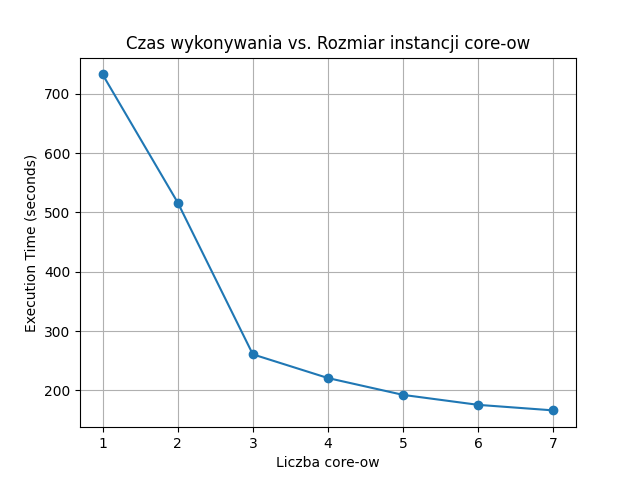

In [53]:
plt.figure()
plt.plot(workers, times, marker='o')
plt.title('Czas wykonywania vs. Rozmiar instancji core-ow')
plt.xlabel('Liczba core-ow')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

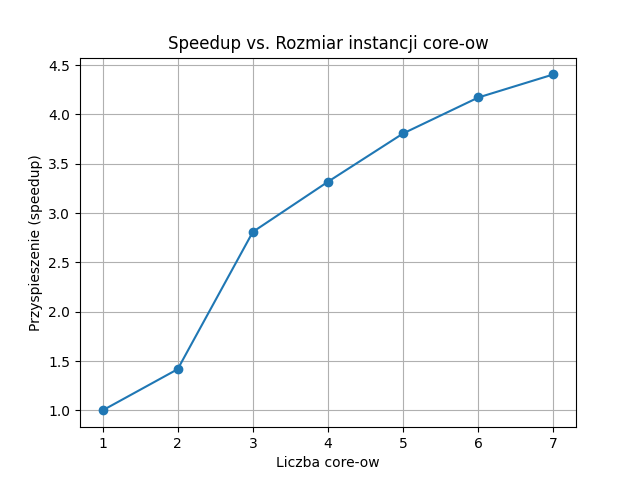

In [54]:
plt.figure()
plt.plot(workers, speedup, marker='o')
plt.title('Speedup vs. Rozmiar instancji core-ow')
plt.xlabel('Liczba core-ow')
plt.ylabel('Przyspieszenie (speedup)')
plt.grid(True)
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

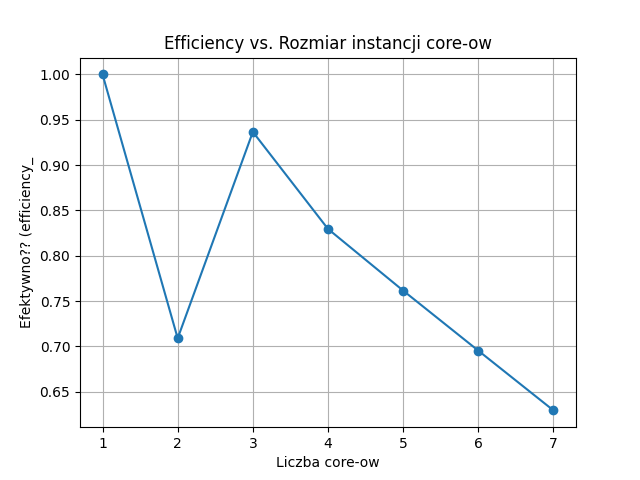

In [55]:
plt.figure()
plt.plot(workers, efficiency, marker='o')
plt.title('Efficiency vs. Rozmiar instancji core-ow')
plt.xlabel('Liczba core-ow')
plt.ylabel('Efektywność (efficiency_')
plt.grid(True)

%matplot plt

[1p.] Dla przykładowego zapytania załącz wybrane wykresy ze Spark UI (https://spark.apache.org/docs/latest/web-ui.html), np. DAG, diagram Gantta, informacje o rozmiarach danych.

![image_name](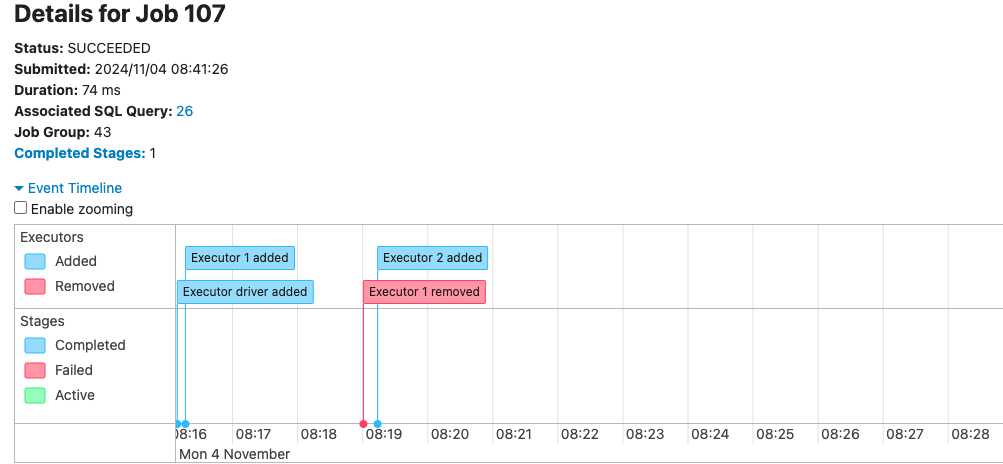
)


![image_name2](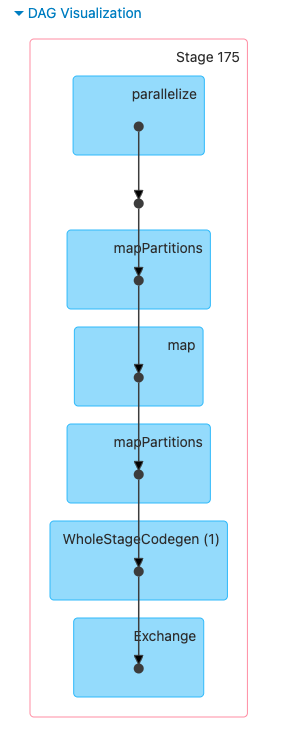
)

![image_name3](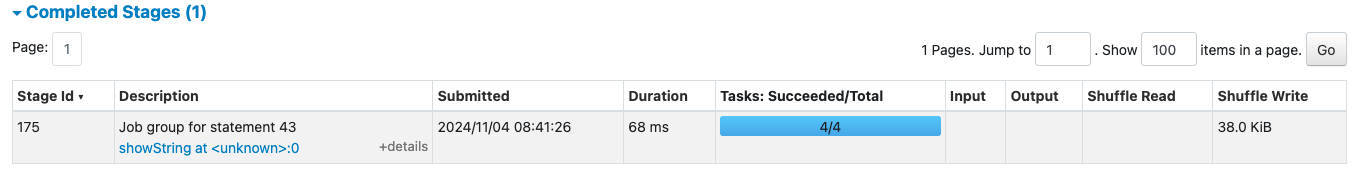
)

![image_name4](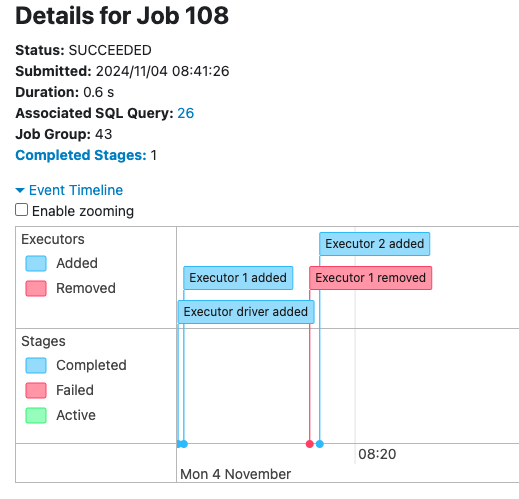
)

![image_name5](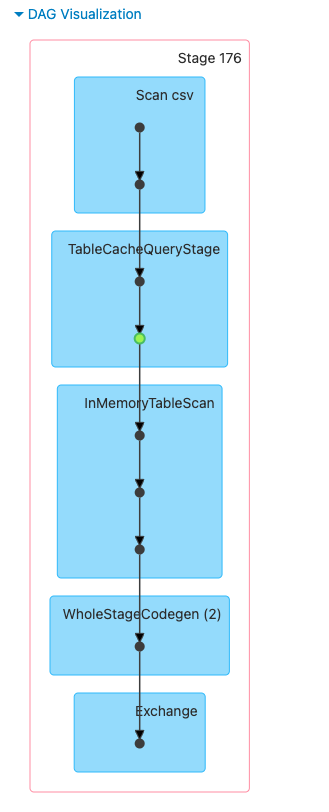
)

![image_name6](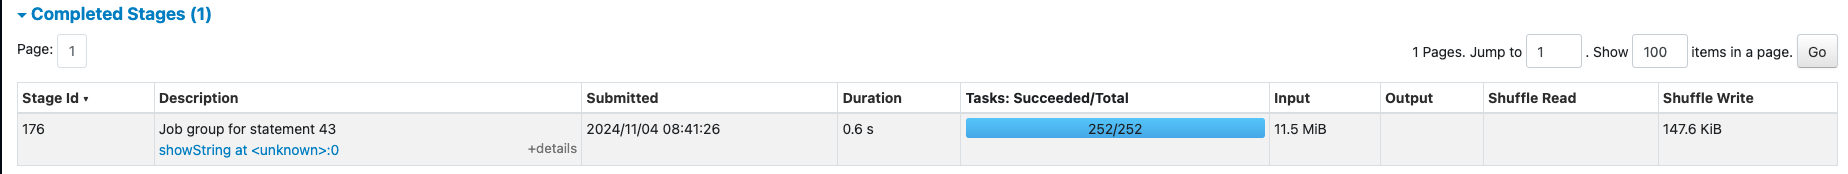
)

![image_name7](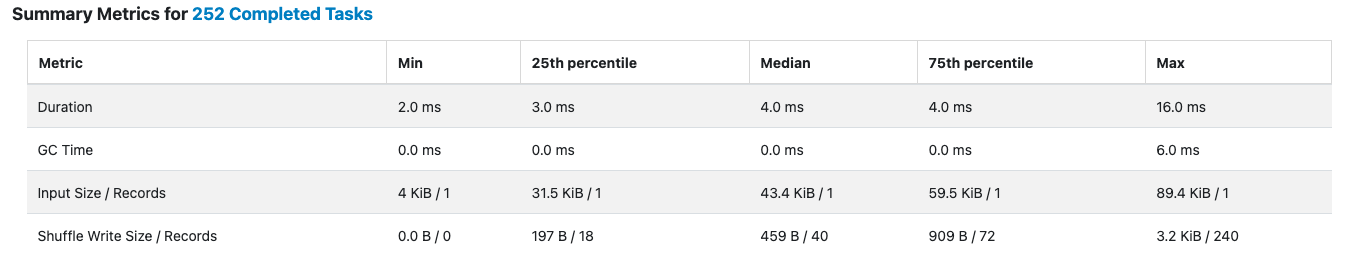
)